In [1]:
!pip install git+https://github.com/NSCC-COGS/Aestheta.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 225kB 4.3MB/s 


In [3]:
from aestheta import core

0 0 0


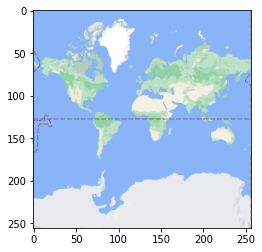

In [4]:
core.getTile(show=True)

In [5]:
!pip install fiona --quiet
!pip install rasterio --quiet

     |████████████████████████████████| 15.3MB 255kB/s 
     |████████████████████████████████| 19.1MB 1.4MB/s 


In [28]:
import fiona, rasterio
import rasterio.features
from matplotlib import pyplot as plt
import imageio

In [9]:
!wget -O benthic_ground_truth.zip https://nscc-my.sharepoint.com/:u:/g/personal/w0001006_campus_nscc_ca/EaYM7nvthFFPm7MXx357X4UBm-xe1uGJVOOg-WpXbPeWGQ?download=1 --quiet --show-progress
!wget -O PQ_Lidar_DEMo13.tif https://nscc-my.sharepoint.com/:i:/g/personal/w0001006_campus_nscc_ca/ETLMGXbg1GpKph8-J0TNs60B-wdefo7rmRwp6FNMdkVOUw?download=1 --quiet --show-progress
!wget -O PQ_RCD_50cm_Cubic.tif https://nscc-my.sharepoint.com/:i:/g/personal/w0001006_campus_nscc_ca/EeGmrgtNc9ZErvlXcVXfNaABsgdvFf7XTX-RprngA9KaCA?download=1 --quiet --show-progress

benthic_ground_trut 100%[===================>]   4.79K  --.-KB/s    in 0s      
PQ_Lidar_DEMo13.tif 100%[===================>] 375.34M  79.2MB/s    in 4.9s    
PQ_RCD_50cm_Cubic.t 100%[===================>]   1.73G  91.1MB/s    in 21s     


In [10]:
!unzip benthic_ground_truth.zip

Archive:  benthic_ground_truth.zip
 extracting: benthic_ground_truth.cpg  
  inflating: benthic_ground_truth.dbf  
  inflating: benthic_ground_truth.prj  
  inflating: benthic_ground_truth.sbn  
  inflating: benthic_ground_truth.sbx  
  inflating: benthic_ground_truth.shp  
  inflating: benthic_ground_truth.shx  


In [12]:
vector_file = r'benthic_ground_truth.shp'
ortho_file = r'PQ_RCD_50cm_Cubic.tif'
dem_file = r'PQ_Lidar_DEMo13.tif'

In [22]:
shapefile = fiona.open(vector_file)
# print(shapefile.crs)
# shapefile.bounds
a = shapefile[0]
# shapefile.close()
print(a)
shapes = [feature["geometry"] for feature in shapefile]

{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('Id', 1), ('Cover_type', 'Eelgrass')]), 'geometry': {'type': 'Polygon', 'coordinates': [[(592548.211913704, 5054935.984943513), (592559.641936565, 5054937.889947325), (592572.5007122837, 5054934.873691291), (592590.4394981605, 5054925.031171603), (592598.5357643532, 5054915.029901607), (592597.1070114964, 5054909.791141126), (592587.1057414941, 5054908.83863922), (592577.4219721267, 5054912.331146203), (592567.5794524413, 5054917.8874073215), (592554.4031760884, 5054926.301174148), (592548.211913704, 5054935.984943513)]]}}


In [23]:
def bounds_to_poly(bounds):
  l,t,r,b = bounds
  poly = [(l,t),
          (r,t),
          (r,b),
          (l,b),
          (l,t)]
  return poly

In [35]:
def clip_raster(raster_file, vector_file, raster_out, masked = False):
  # https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
  import fiona
  import rasterio
  import rasterio.mask

  with fiona.open(vector_file, "r") as shapefile:
    if masked: # iterate over every poly to make clip geometry
      shapes = [feature["geometry"] for feature in shapefile]
      print(shapes)
    else: # just clip by the whole bounds
      shapes = shapefile[0]["geometry"] #get a json template from the first poly
      print(shapefile.bounds)
      poly_bounds = bounds_to_poly(shapefile.bounds)
      shapes['coordinates'] = [poly_bounds] # replace coords with bounds
      shapes = [shapes]
      # print(shapes)
  
  # return
  # input('yeah?')
  with rasterio.open(raster_file) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

  # print(src.meta)

  out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

  with rasterio.open(raster_out, "w", **out_meta) as dest:
      dest.write(out_image)

In [34]:
ortho_clip_file = ortho_file.replace('.tif', '_clipped.tif')
clip_raster(ortho_file, vector_file, ortho_clip_file, masked=False)

(591310.2537867589, 5051605.3409948815, 594720.8720664426, 5055134.216354804)
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 21710, 'height': 21450, 'count': 4, 'crs': CRS.from_epsg(2961), 'transform': Affine(0.5, 0.0, 586460.0,
       0.0, -0.5, 5059025.0)}


255


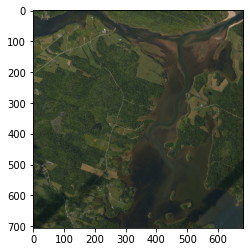

In [45]:
ortho = imageio.imread(ortho_clip_file)
print(ortho.max())
plt.imshow(ortho[::10,::10,0:3])
plt.show()

255


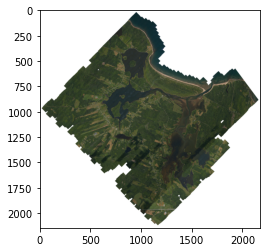

In [32]:
# ortho = imageio.imread(ortho_file)
# print(ortho.max())
# plt.imshow(ortho[::10,::10,0:3])
# plt.show()

In [37]:
def snap_raster(raster_file, snap_raster_file, raster_out):
  #https://stackoverflow.com/questions/59102791/how-to-find-corresponding-pixels-between-two-geospatial-raster-data-with-differe

  from rasterio.warp import calculate_default_transform, reproject, Resampling

  raz = rasterio.open(raster_file)
  snp = rasterio.open(snap_raster_file)


  kwargs = raz.meta.copy()
  kwargs.update({
      'crs': snp.crs,
      'transform': snp.transform,
      'width': snp.width,
      'height': snp.height
  })

  with rasterio.open(raster_out, 'w', **kwargs) as dst:
      reproject(
          source=rasterio.band(raz, 1),
          destination=rasterio.band(dst, 1),
          src_transform=raz.transform,
          src_crs=raz.crs,
          dst_transform=snp.transform,
          dst_crs=snp.crs,
          resampling=Resampling.nearest)

In [38]:
dem_clip_file = dem_file.replace('.tif', '_clipped.tif')
snap_raster(dem_file, ortho_clip_file, dem_clip_file)

38.60896


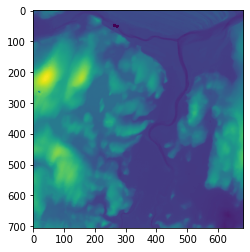

In [44]:
dem = imageio.imread(dem_clip_file)
print(dem.max())
plt.imshow(dem[::10,::10],vmin=-10)
plt.show()

In [55]:
import numpy as np

In [69]:
print(ortho.dtype)
print(dem.dtype)

uint8
uint8


In [57]:
dem[dem<-10] = -10

In [59]:
dem -= dem.min()

In [61]:
dem /= dem.max()

In [64]:
dem *= 255

In [68]:
dem = dem.astype(np.uint8)

38.60896


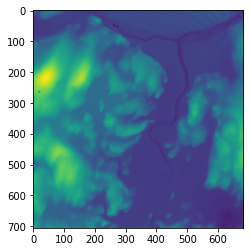

In [58]:
print(dem.max())
plt.imshow(dem[::10,::10])
plt.show()

In [71]:
image = np.dstack((ortho,dem))

In [72]:
image.shape

(7059, 6822, 5)

255


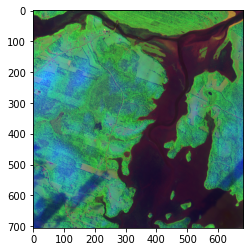

In [78]:
print(image.max())
plt.imshow(image[::10,::10,[0,3,4]])
plt.show()

In [80]:
def add_features_from_vec(raster_file , vector_file):
  src = rasterio.open(raster_file)

  shapefile = fiona.open(vector_file)
  geom = [shapes['geometry'] for shapes in shapefile]
  # attrib = [shapes['properties'] for shapes in shapefile]

  image = rasterio.features.rasterize(geom, out_shape=src.shape, transform=src.transform)
  return image

In [144]:
shp = fiona.open(vector_file)
print(shp[0]['properties'])
print(shp[12]['properties'])

OrderedDict([('Id', 1), ('Cover_type', 'Eelgrass')])
OrderedDict([('Id', 3), ('Cover_type', 'Dark SAV')])


In [146]:
def add_features_from_vec_col(raster_file , vector_file,col):
# https://gis.stackexchange.com/questions/297920/rasterizing-by-attribute-in-rasterio

  src = rasterio.open(raster_file)
  shapefile = fiona.open(vector_file)
  geom = [[shapes['geometry'],shapes['properties'][col]] for shapes in shapefile]

  varray = rasterio.features.rasterize(geom
                    out_shape=src.shape, 
                    transform=src.transform,
                    fill=-1,
                    default_value=1,
                    all_touched=True)
  return varray

In [83]:
vecarr = add_features_from_vec(ortho_clip_file,vector_file)

1


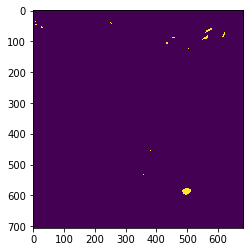

In [90]:
print(vecarr.max())
# plt.imshow(vecarr[::10,::10])
plt.imshow(vecarr[::10,::10], interpolation='nearest')
plt.show()

In [91]:
print(vecarr.shape)
print(image.shape)

(7059, 6822)
(7059, 6822, 5)


In [96]:
vecarr  = np.repeat(vecarr[:,:, np.newaxis], 3, axis=2)

In [101]:
print(vecarr.shape)
print(image.shape)
print(vecarr.dtype)

(7059, 6822, 3)
(7059, 6822, 5)
uint8


In [103]:
vecarr[vecarr==1]=255

255


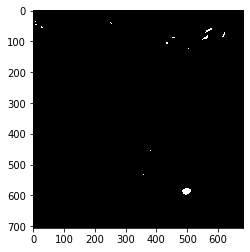

In [104]:
print(vecarr.max())
plt.imshow(vecarr[::10,::10], interpolation='nearest')
plt.show()

In [121]:
((vecarr/255).mean())*100

0.21909815784362058

255


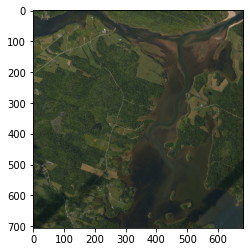

In [115]:
print(image.max())
plt.imshow(image[::10,::10,[0,1,2]])
plt.show()

In [106]:
model, classes = core.simpleClassifier(image[::10,::10], vecarr[::10,::10])

training  classifier...
      Iter       Train Loss   Remaining Time 
         1           0.0249            4.63s
         2           0.0236            2.54s
         3           0.0230            1.78s
         4           0.0225            1.40s
         5           0.0221            1.17s
         6           0.0219            1.01s
         7           0.0216            0.90s
         8           0.0215            0.81s
         9           0.0213            0.74s
        10           0.0212            0.69s
        20           0.0204            0.40s
        30           0.0198            0.29s
        40           0.0191            0.22s
        50           0.0182            0.17s
        60           0.0177            0.14s
        70           0.0171            0.10s
        80           0.0164            0.07s
        90           0.0159            0.03s
       100           0.0155            0.00s


In [107]:
image_class = core.classifyImage(image[::10,::10], model, classes)

applying classification...


0


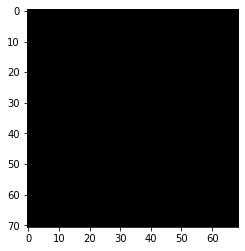

In [112]:
print(image_class.ptp())
plt.imshow(image_class[::10,::10,0:4])
plt.show()

In [132]:
vic = add_features_from_vec(ortho_clip_file,vector_file)

In [125]:
vic.shape

(7059, 6822)

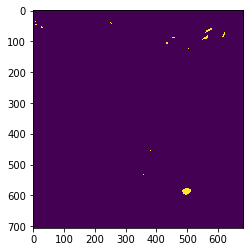

In [127]:
plt.imshow(vic[::10,::10], interpolation='nearest')
plt.show()

In [138]:
vic = vic[vic==1]
vic.shape

(105510,)

In [135]:
vic[vic==1]

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [139]:
print(vic.min(), vic.max())

1 1


In [147]:
vic2 = add_features_from_vec_col(ortho_clip_file , vector_file,'Id')

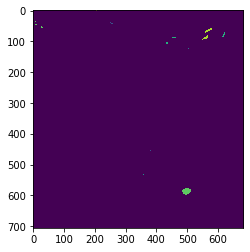

In [148]:
plt.imshow(vic2[::10,::10], interpolation='nearest')
plt.show()

In [151]:
mask = vic2>-1

In [152]:
vic2_flat = vic2[mask]

In [153]:
image_flat = image[mask]

In [158]:
arr = np.zeros((5, 7059, 6822))

In [159]:
arr.shape

(5, 7059, 6822)

In [162]:
vic2_flat

array([7, 7, 7, ..., 1, 1, 1], dtype=int16)

In [163]:
from sklearn.ensemble import GradientBoostingClassifier

classModel = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=1,
        random_state=0,
        verbose=1
    ).fit(image_flat, vic2_flat)

      Iter       Train Loss   Remaining Time 
         1      109178.9650           55.19s
         2       93514.5914           53.44s
         3       81379.1895           52.67s
         4       71721.3839           52.08s
         5       63865.3862           51.46s
         6       57186.5990           50.76s
         7       51742.0467           50.08s
         8       46862.1967           49.41s
         9       42712.3363           48.63s
        10       39247.1593           47.87s
        20       19096.4206           41.81s
        30       11649.7675           36.38s
        40        8258.8133           31.10s
        50        7006.8314           25.78s
        60        5874.4460           20.57s
        70        5102.1705           15.39s
        80        4549.2828           10.28s
        90        4119.8497            5.13s
       100        3784.7878            0.00s


In [165]:
example_model, example_classes = core.loadModel()
print(example_model)
print(example_classes)

['simpleClassifier_20210302180953_64_HelloEarth100.aist', 'simpleClassifier_20210317122725_64_HelloEarth100.aist', 'simpleClassifier_20210317123255_64_HelloEarth100.aist', 'simpleClassifier_20210228223109_32_HelloEarth100.aist', 'simpleClassifier_20210228221023_32_HelloEarth.aist', 'simpleClassifier_20210317122843_64_HelloEarth100.aist', 'simpleClassifier_20210317122912_64_HelloEarth100.aist']
getting most recent model
20210302180953
20210317122725
20210317123255
20210228223109
20210228221023
20210317122843
20210317122912
/usr/local/lib/python3.7/dist-packages/aestheta/Models/simpleClassifier_20210317123255_64_HelloEarth100.aist
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=1,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_spl

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.24.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previ

In [169]:
y = vic2_flat
print(y)
print('-------------')
#lets make our classes fit our classify image tool
classes = np.arange(y.max()+1, dtype=float)
print(classes)
print('-------------')
classes  = np.repeat(classes[:, np.newaxis], 3, axis=1)
classes -= classes.min()
classes /= classes.max()
classes *= 255
print(classes)
print('-------------')
alpha  = (np.ones((classes.shape[0],1))*255)
print(alpha)
print('-------------')
classes = np.hstack((classes,alpha)).astype(int)
print(classes)

[7 7 7 ... 1 1 1]
-------------
[0. 1. 2. 3. 4. 5. 6. 7.]
-------------
[[  0.           0.           0.        ]
 [ 36.42857143  36.42857143  36.42857143]
 [ 72.85714286  72.85714286  72.85714286]
 [109.28571429 109.28571429 109.28571429]
 [145.71428571 145.71428571 145.71428571]
 [182.14285714 182.14285714 182.14285714]
 [218.57142857 218.57142857 218.57142857]
 [255.         255.         255.        ]]
-------------
[[255.]
 [255.]
 [255.]
 [255.]
 [255.]
 [255.]
 [255.]
 [255.]]
-------------
[[  0   0   0 255]
 [ 36  36  36 255]
 [ 72  72  72 255]
 [109 109 109 255]
 [145 145 145 255]
 [182 182 182 255]
 [218 218 218 255]
 [255 255 255 255]]


In [170]:
ortho_class = core.classifyImage(image[::10,::10],classModel,classes)

applying classification...


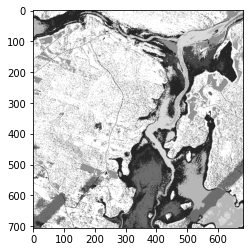

In [171]:
plt.imshow(ortho_class)

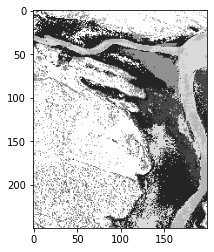

In [172]:
plt.imshow(ortho_class[50:300,300:500])